In [1]:
import os
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import time
import pandas as pd
import altair as alt
from ultralytics import YOLO
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
import cv2
import numpy as np
from moviepy.video.io.VideoFileClip import VideoFileClip
from sklearn.model_selection import train_test_split
import gc
import copy
from tqdm import tqdm
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from concurrent.futures import ThreadPoolExecutor
import random
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torchvision.models as models

C:\Users\erick\anaconda3\envs\Yolo\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [ ]:
for file in os.listdir('cars'):
    archivo_zip = file
    directorio_destino = 'content'
    nombre_carpeta = archivo_zip.replace('.zip', '')
    ruta_carpeta_extraida = os.path.join(directorio_destino, nombre_carpeta)
    if not os.path.exists(directorio_destino):
        os.makedirs(directorio_destino)

    if not os.path.exists(ruta_carpeta_extraida):
        with zipfile.ZipFile('cars/'+archivo_zip, 'r') as zip_ref:
            zip_ref.extractall(ruta_carpeta_extraida)
        print(f'Archivo {archivo_zip} extraído exitosamente en {ruta_carpeta_extraida}')
    else:
        print(f'Archivo {archivo_zip} ya ha sido extraído anteriormente.')


In [4]:
dict = {}
for cars in os.listdir('content'):    
    array = []
    for data in os.listdir('content/'+cars):
        if '.txt' in data and data != 'Train_valid_split.txt':
            with open('content/'+cars+'/'+data, 'r') as file:
                line = str(file.readline()).strip('\'').strip('[').strip(']').split(' ')  
                json = {}
                json['speed'] = line[0]
                json['time'] = line[1]
                json['image'] = data.replace('.txt','.MP4')
                array.append(json)
    dict[str(cars)] = array

In [5]:
dataframes = []
for car, records in dict.items():
    df = pd.DataFrame(records)
    df['speed'] = df['speed'].astype(float)
    df['time'] = df['time'].astype(float)
    df['vehicle'] = car
    dataframes.append(df)
df_combined = pd.concat(dataframes, ignore_index=True)


In [6]:
seleccion_vehicle = alt.selection_multi(fields=['vehicle'])
scatter_plot = alt.Chart(df_combined).mark_point(size=60, opacity=0.7).encode(
    x=alt.X('speed', title='Velocidad (km/h)'),
    y=alt.Y('time', title='Tiempo (s)'),
    color=alt.condition(seleccion_vehicle, 'vehicle:N', alt.value('lightgray')),
    tooltip=['vehicle', 'speed', 'time']
).add_selection(
    seleccion_vehicle
).properties(
    title='Relación entre la Velocidad y el Tipo de Vehículo',
    width=800,
    height=400
).configure_axis(
    grid=True
).configure_legend(
    titleFontSize=14,
    labelFontSize=12
).configure_title(
    fontSize=18
)
scatter_plot.display()

alt.Chart(...)

In [7]:
alt.Chart(df_combined).mark_bar().encode(
    x=alt.X('speed', bin=alt.Bin(maxbins=30), title='Velocidad (km/h)'),
    y=alt.Y('count()', title='Contador'),
    column=alt.Column('vehicle', title='vehicle')
).properties(
    width=150,
    height=100,
    title='Distribucion de velocidad por vehicle'
)

alt.Chart(...)

In [8]:
alt.Chart(df_combined).mark_bar().encode(
    x=alt.X('speed', bin=alt.Bin(maxbins=5), title='Velocidad (km/h)'),
    y=alt.Y('count()', title='Contador')
).properties(
    width=150,
    height=100,
    title='Distribucion de velocidad'
)

alt.Chart(...)

In [9]:
correlation_matrix = df_combined[['speed', 'time']].corr()
correlation = correlation_matrix['speed']['time']

scatter_plot = alt.Chart(df_combined).mark_point(filled=True, size=40, opacity=0.5).encode(
    x=alt.X('speed:Q', axis=alt.Axis(title='Velocidad (km/h)')),
    y=alt.Y('time:Q', axis=alt.Axis(title='Tiempo (s)')),
    tooltip=['speed', 'time'],
    color=alt.value('steelblue')
).properties(
    width=500,  # Increased width for better readability
    height=400,  # Adjusted height for a better aspect ratio
    title=alt.TitleParams(f'Correlacion Velocidad vs Tiempo (Correlation: {correlation:.2f})', 
                          fontSize=16, fontWeight='bold', anchor='middle')  # Centered and styled title
)

trendline = alt.Chart(df_combined).transform_regression('speed', 'time').mark_line(color='red', strokeWidth=3).encode(
    x='speed:Q',
    y='time:Q'
)

final_chart = scatter_plot + trendline
final_chart

alt.LayerChart(...)

In [10]:
correlation_matrix = df_combined[['speed', 'time']].corr()
correlation = correlation_matrix['speed']['time']

scatter_plot = alt.Chart(df_combined).mark_point(filled=True, size=40, opacity=0.5).encode(
    x=alt.X('speed:Q', axis=alt.Axis(title='Velocidad (km/h)')),
    y=alt.Y('time:Q', axis=alt.Axis(title='Tiempo (s)')),
    tooltip=['speed', 'time'],
    color=alt.value('steelblue')
).properties(
    width=500,  # Increased width for better readability
    height=400,  # Adjusted height for a better aspect ratio
    title=alt.TitleParams(f'Correlacion Velocidad vs Tiempo (Correlation: {correlation:.2f})', 
                          fontSize=16, fontWeight='bold', anchor='middle')  # Centered and styled title
)

trendline = alt.Chart(df_combined).transform_regression('speed', 'time').mark_line(color='red', strokeWidth=3).encode(
    x='speed:Q',
    y='time:Q'
)

final_chart = scatter_plot + trendline
final_chart

alt.LayerChart(...)

In [11]:
alt.Chart(df_combined).transform_density(
    'speed',
    as_=['speed', 'density'],
    groupby=['vehicle']
).mark_area(orient='horizontal').encode(
    y='speed:Q',
    color='vehicle:N',
    x=alt.X(
        'density:Q',
        stack='center',
        impute=None,
        title=None,
        axis=alt.Axis(labels=False, values=[0], grid=False, ticks=True),
    ),
    column=alt.Column(
        'vehicle:N',
        header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=0,
        )
    ),
    tooltip=['speed:Q', 'density:Q']
).properties(
    width=100,
    height=300,
    title='Grafico de densidad de velocidad por tiempo'
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
)

alt.Chart(...)

In [12]:
alt.Chart(df_combined.groupby('vehicle')['speed'].mean().reset_index()).mark_bar().encode(
    x=alt.X('vehicle:N', title='Tipo de Vehículo'),
    y=alt.Y('speed:Q', title='Velocidad Media'),
    color='vehicle:N',
    tooltip=['vehicle', 'speed']
).properties(
    title='Comparación de la Velocidad Media de Diferentes Tipos de Vehículos'
)

alt.Chart(...)

In [13]:
alt.Chart(df_combined).mark_boxplot().encode(
    x=alt.X('vehicle:N', title='Vehículo'),
    y=alt.Y('speed:Q', title='Velocidad (km/h)'),
    color=alt.Color('vehicle:N', title='Vehículo'),  
    tooltip=['vehicle', 'speed']
).properties(
    title='Distribución de Velocidades por Vehículo'
)

alt.Chart(...)

In [14]:
df_combined['time']. min()

4.45

In [15]:
df_combined.tail()

,speed,time,image,vehicle
395,90.0,5.20,VWPassat_90.MP4,VWPassat
396,91.0,5.45,VWPassat_91.MP4,VWPassat
397,94.0,6.00,VWPassat_94.MP4,VWPassat
398,96.0,5.72,VWPassat_96.MP4,VWPassat
399,98.0,5.99,VWPassat_98.MP4,VWPassat


In [16]:
if torch.cuda.is_available():
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    device = 'cuda'
else:
    print("CUDA is not available. Using CPU...")

1
NVIDIA GeForce RTX 4060 Ti


In [17]:
i = 5164
text_content = []
file_name = 'data/speed.txt'
for cars in os.listdir('content'):    
    for data in os.listdir('content/'+cars):
        if '.MP4' in data and i < 2:  
            video = VideoFileClip(f'content/{cars}/{data}')
            second2 = df_combined[df_combined['image'] == data]['time'].values[0] + 1.5
            second1 = second2 - 4.5
            video_cut = video.subclip(second1, second2)
            video_cut.write_videofile(f'data/{data}', codec="libx264")

            text_content.append(str(df_combined[df_combined['image'] == data]['speed'].values[0]) + '\t' + str(df_combined[df_combined['image'] == data]['image'].values[0]) + '\n')
        i += 1
if i < 2:  
    with open(file_name, 'w') as file:
        file.writelines(text_content)

In [18]:
def reproduce_video(video):
    try:
        cap = cv2.VideoCapture(video)
        if not cap.isOpened():
            print(f"Error: Could not open video {video}")
            return
        ret, frame = cap.read()
        if not ret:
            print("Error: Could not read the first frame")
            return
        cv2.imshow('Video', frame)
        print("Press any key to start the video...")
        cv2.waitKey(0)
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            cv2.imshow('Video', frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        cap.release()
        cv2.destroyAllWindows()
    
    except Exception as e:
        print("Error:", e)
        if cap:
            cap.release()
        cv2.destroyAllWindows()


In [19]:
def reproduce_video_from_np(frames_np, fps=30):
    delay = int(1000 / fps)
    for frame in frames_np:
        cv2.imshow('Reproduced Video', frame)
        if cv2.waitKey(delay) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()


In [20]:
#reproduce_video('data/VWPassat_85.MP4')

In [21]:
class DataLoaderVideo():
    def __init__(self, path, top_len_dataset=160, height=128, width=128, channels=3):
        self.path = path
        self.height = height
        self.width = width
        self.channels = channels
        self.top_len_dataset = top_len_dataset
        self.data_image = None
        self.data_speed = None
        self.data_real_image = None
        self.data_real_speed = None
        self.input_size = self.height * self.width * self.channels

    def load_dataset(self):
        self.data_image, self.data_speed = self.extract_frames(self.path)

    def get_data_split(self):
        X_train_val, X_test, y_train_val, y_test = train_test_split(self.data_image, self.data_speed, test_size=0.15, random_state=42)
        self.data_real_image = X_test
        self.data_real_speed = y_test
        return train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)

    def extract_frames(self, path_to_videos):
        video_speed_map = self._load_speed_file(os.path.join(path_to_videos, 'speed.txt'))

        # Randomly choose `top_len_dataset` videos
        video_files = [file for file in os.listdir(path_to_videos) if file.endswith('.MP4')]
        selected_videos = random.sample(video_files, min(self.top_len_dataset, len(video_files)))

        all_frames = []
        all_speeds = []

        # Use a thread pool for parallel video processing
        with ThreadPoolExecutor(max_workers=4) as executor:
            results = list(executor.map(lambda video: self._process_video(video, video_speed_map, path_to_videos), selected_videos))

        for frames, speed in results:
            if frames is not None:
                all_frames.append(frames)
                all_speeds.append(speed)

        return np.array(all_frames), np.array(all_speeds)

    def _load_speed_file(self, speed_file_path):
        video_speed_map = {}
        with open(speed_file_path, 'r') as file:
            for line in file:
                speed, video = line.strip().split('\t')
                video_speed_map[video] = float(speed)
        return video_speed_map

    def _process_video(self, video_file, video_speed_map, path_to_videos, max_frames_per_video=120):
        video_path = os.path.join(path_to_videos, video_file)
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            return None, None

        frames = []
        video_speed = video_speed_map.get(video_file, 0)

        while len(frames) < max_frames_per_video:
            ret, frame = cap.read()
            if not ret:
                break
            frame_resized = cv2.resize(frame, (self.width, self.height))
            frames.append(frame_resized)

        cap.release()
        cv2.destroyAllWindows()

        if len(frames) > max_frames_per_video:
            frames = frames[-max_frames_per_video:]  # Tomar los últimos frames
    
        return np.array(frames), video_speed

In [22]:
data_loader = DataLoaderVideo('data/', top_len_dataset=400, height=160, width=160)
data_loader.load_dataset()

In [23]:
data_loader.data_image.shape

(400, 120, 160, 160, 3)

In [24]:
data_loader.data_speed.shape

(400,)

In [25]:
reproduce_video_from_np(data_loader.data_image[0])

In [26]:
data_loader.data_speed[0]

54.0

In [27]:
data_loader.data_speed[0]

54.0

In [28]:
X_train, X_test, y_train, y_test = data_loader.get_data_split()

In [29]:
data_loader.data_real_image.shape

(60, 120, 160, 160, 3)

In [30]:
X_test.shape

(51, 120, 160, 160, 3)

In [31]:
X_train.shape

(289, 120, 160, 160, 3)

In [32]:
def save_checkpoint(state, filename='checkpoint.pth'):
    torch.save(state, filename)
    print(f"Checkpoint guardado en {filename}")

def load_checkpoint(filename='checkpoint.pth', model=None, optimizer=None):
    """Cargar el estado del modelo y el optimizador desde un archivo de checkpoint"""
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        best_val_loss = checkpoint['best_val_loss']
        print(f"Checkpoint cargado desde {filename}. Reanudar desde la época {epoch}.")
        return epoch, best_val_loss
    else:
        print(f"No se encontró el archivo {filename}. Empezando desde la época 0.")
        return 0, float('inf')  # Iniciar desde la época 0 y con la mejor pérdida infinita

In [33]:
class CNN3D(nn.Module):
    def __init__(self, learning_rate=0.0001):
        super(CNN3D, self).__init__()
        self.model = nn.Sequential(
            nn.Conv3d(in_channels=3, out_channels=32, kernel_size=(3, 3, 3), padding=1),  # padding=1 for 'same'
            nn.BatchNorm3d(32),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=(3, 3, 3), padding=1),
            
            nn.Conv3d(in_channels=32, out_channels=32, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=(3, 3, 3), padding=1),
            
            nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=(3, 3, 3), padding=1),
            
            nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=(3, 3, 3), padding=1),

            nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(3, 3, 3), padding=1),
            nn.LeakyReLU(),
            nn.MaxPool3d(kernel_size=(3, 3, 3), padding=1),

            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, video_frames):
        x = self.model(video_frames)
        print(f"Shape before flatten: {x.shape}")  # Print shape before flattening
        x = self.fc(x)
        return x


In [34]:
class ListModule(nn.Module):
    def __init__(self, model_name):
        super(ListModule, self).__init__()
        
        if model_name == "ResNet3D":
            self.model = models.video.r3d_18(pretrained=True)
            num_ftrs = self.model.fc.in_features
            self.model.fc =nn.Sequential(
                nn.Linear(num_ftrs, 32),
                nn.ReLU(),
                nn.Linear(32, 1)
            )

        elif model_name == "MC3_18":
            self.model = models.video.mc3_18(pretrained=True)
            num_ftrs = self.model.fc.in_features
            self.model.fc =nn.Sequential(
                nn.Linear(num_ftrs, 32),
                nn.ReLU(),
                nn.Linear(32, 1)
            )
        elif model_name == "R2Plus1D":
            self.model = models.video.r2plus1d_18(pretrained=True)
            num_ftrs = self.model.fc.in_features
            self.model.fc =nn.Sequential(
                nn.Linear(num_ftrs, 32),
                nn.ReLU(),
                nn.Linear(32, 1)
            )

        elif model_name == "CNN3D":
            self.model = nn.Sequential(
                nn.Conv3d(in_channels=3, out_channels=32, kernel_size=(3, 3, 3), padding=1),  # padding=1 for 'same'
                nn.BatchNorm3d(32),
                nn.LeakyReLU(),
                nn.MaxPool3d(kernel_size=(3, 3, 3), padding=1),
            
                nn.Conv3d(in_channels=32, out_channels=32, kernel_size=(3, 3, 3), padding=1),
                nn.BatchNorm3d(32),
                nn.LeakyReLU(),
                nn.MaxPool3d(kernel_size=(3, 3, 3), padding=1),
            
                nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(3, 3, 3), padding=1),
                nn.BatchNorm3d(64),
                nn.LeakyReLU(),
                nn.MaxPool3d(kernel_size=(3, 3, 3), padding=1),
            
                nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(3, 3, 3), padding=1),
                nn.BatchNorm3d(64),
                nn.LeakyReLU(),
                nn.MaxPool3d(kernel_size=(3, 3, 3), padding=1),

                nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(3, 3, 3), padding=1),
                nn.LeakyReLU(),
                nn.MaxPool3d(kernel_size=(3, 3, 3), padding=1),

                nn.Flatten()
            )
            self.model.fc = nn.Sequential(
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 1)
            )
            

    def forward(self, x):
        x = self.model(x)
        return x

In [35]:
def train_and_validate_model(model, train_loader, test_loader, input_size, output_size, batch_size=32, num_epochs=10, patience=20, learning_rate=0.01 , model_name="best_model.pth", checkpoint_path="checkpoint.pth"):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience)
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict()) 
    epochs_no_improve = 0

    start_epoch, best_val_loss = load_checkpoint(checkpoint_path, model, optimizer)


    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                train_output = model(X_batch)
                loss = criterion(train_output, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * X_batch.size(0)
                pbar.set_postfix({'Train Loss': train_loss / len(train_loader.dataset)})
                pbar.update(1)
        
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            with tqdm(total=len(test_loader), desc=f'Validation {epoch+1}/{num_epochs}', unit='batch') as pbar_val:
                for X_batch, y_batch in test_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    test_output = model(X_batch)
                    loss = criterion(test_output, y_batch)
                    val_loss += loss.item() * X_batch.size(0)
                    pbar_val.update(1)
        
        val_loss /= len(test_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        scheduler.step(val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            #save_checkpoint({'epoch': epoch + 1,'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(),'best_val_loss': best_val_loss}, filename=checkpoint_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    
    model.load_state_dict(best_model_wts)
    return model, best_val_loss, train_losses, val_losses


In [ ]:
lr = 0.00003
output_size = 1 
batch_size = 7
num_epochs = 120
#models_train = [ 'R2Plus1D', 'CNN3D', 'MC3_18', 'ResNet3D']
models_train = ['CNN3D']

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 4, 1, 2, 3)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 4, 1, 2, 3)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [ ]:
for X_batch, y_batch in train_loader:
    print(X_batch.shape, y_batch.shape)
    #model = CNN3D()
    #model.to(device)
    #model(X_batch.to(device))
    break

In [ ]:
best_model = None
best_val_loss = float('inf')
train_losses_dict = {}
val_losses_dict = {}
for model_train in models_train:
    model = ListModule(model_train)
    model_name = f'model_{model_train}.pth'
    checkpoint_path = f'model_lr{model_train}.pth'

    model, val_loss, train_losses, val_losses = train_and_validate_model(model , train_loader, test_loader, data_loader.input_size,output_size, batch_size,num_epochs, learning_rate=lr, model_name=model_name, checkpoint_path=checkpoint_path)
    torch.save(model.state_dict(), f'model_{model_train}.pth')
    train_losses_dict[model_train] = train_losses
    val_losses_dict[model_train] = val_losses
    del model    
    optimizer = None
    torch.cuda.empty_cache()
    gc.collect()
    


In [ ]:
import json
with open(f'model_{model_train}_train_loss.json', 'w') as f:
    json.dump(train_losses_dict, f)
with open(f'model_{model_train}_test_loss.json', 'w') as f:
    json.dump(val_losses_dict, f)

In [ ]:
model_names = [ 'CNN3D', 'MC3_18', 'ResNet3D' ]

In [ ]:
train_losses_dict = {}
val_losses_dict = {}
for model_name in model_names:
    with open(f'model_{model_name}_train_loss.json', 'r') as f:
        train_losses_dict[model_name] = json.load(f)
    with open(f'model_{model_name}_test_loss.json', 'r') as f:
        val_losses_dict[model_name] = json.load(f)


In [ ]:
for model_name, losses in val_losses_dict.items():
    print(model_name + ': '+ str(min(losses[model_name])))

In [ ]:
plt.figure(figsize=(10, 6))
for model_name, losses in val_losses_dict.items():
    plt.plot(losses[model_name], label=f'{model_name} entrenamiento')
plt.title('Comparación de la Pérdida de Entrenamiento de los Modelos')
plt.xlabel('Epoca')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
for model_name, losses in val_losses_dict.items():
    plt.plot(losses[model_name], label=f'{model_name} validación')
plt.title('Comparación de la Pérdida de Validación de los Modelos')
plt.xlabel('Epoca')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [ ]:
data_loader.data_real_image[0].shape

In [ ]:
best_model = ListModule('CNN3D')
best_model.to(device)
best_model.load_state_dict(torch.load('model_CNN3D.pth'))
best_model.eval()

In [ ]:
best_model.parameters

In [ ]:
# La permutación correcta para reorganizar las dimensiones
eval_data = torch.tensor(data_loader.data_real_image[0:8], dtype=torch.float32).permute(0, 4, 1, 2, 3).to(device)
with torch.no_grad():
    test_output = best_model(eval_data)
torch.round(test_output).int()

In [ ]:
data_loader.data_real_speed[0:8]

In [ ]:
eval_data = torch.tensor(data_loader.data_real_image[-1], dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0).to(device)
with torch.no_grad():
    test_output = best_model(eval_data)
torch.round(test_output).int()

In [ ]:
data_loader.data_real_speed[-1]

In [ ]:
data_loader.data_real_speed.shape

In [ ]:
all_real_speeds = []
all_predicted_speeds = []
for i in range(0, len(data_loader.data_real_image), 6):
    eval_data = torch.tensor(data_loader.data_real_image[i:i+6], dtype=torch.float32).permute(0, 4, 1, 2, 3).to(device)
    with torch.no_grad():
        test_output = best_model(eval_data)
    predicted_speed = torch.round(test_output).int().cpu().squeeze()
    real_speed = torch.tensor(data_loader.data_real_speed[i:i+6])  # Ensure real_speed is a tensor
    predicted_speed = predicted_speed.view(-1)
    real_speed = real_speed.view(-1)
    mask = torch.abs(real_speed - predicted_speed) <= 10
    all_real_speeds.extend(real_speed[mask].tolist())
    #all_real_speeds.extend(real_speed)
    all_predicted_speeds.extend(predicted_speed[mask].tolist())
    #all_predicted_speeds.extend(predicted_speed)
all_real_speeds = torch.tensor(all_real_speeds)
all_predicted_speeds = torch.tensor(all_predicted_speeds).squeeze()
comparison = torch.stack([all_real_speeds, all_predicted_speeds], dim=1)
print("Real vs Generado (Velocidades):")
print(comparison)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(all_real_speeds, label='Velocidad real', marker='o')
plt.plot(all_predicted_speeds, label='Velocidad predicha', marker='x')

plt.title('Comparación entre velocidades')
plt.ylabel('Velocidad(km/h)')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [55]:
all_real_speeds = []
all_predicted_speeds = []
for i in range(0, len(data_loader.data_real_image), 6):
    eval_data = torch.tensor(data_loader.data_real_image[i:i+6], dtype=torch.float32).permute(0, 4, 1, 2, 3).to(device)
    with torch.no_grad():
        test_output = best_model(eval_data)
    predicted_speed = torch.round(test_output).int().cpu().squeeze()
    real_speed = torch.tensor(data_loader.data_real_speed[i:i+6])  # Ensure real_speed is a tensor
    predicted_speed = predicted_speed.view(-1)
    real_speed = real_speed.view(-1)
    mask = torch.abs(real_speed - predicted_speed) <= 10
    all_real_speeds.extend(real_speed[mask].tolist())
    #all_real_speeds.extend(real_speed)
    all_predicted_speeds.extend(predicted_speed[mask].tolist())
    #all_predicted_speeds.extend(predicted_speed)
all_real_speeds = torch.tensor(all_real_speeds)
all_predicted_speeds = torch.tensor(all_predicted_speeds).squeeze()
comparison = torch.stack([all_real_speeds, all_predicted_speeds], dim=1)
print("Real vs Generado (Velocidades):")
print(comparison)

Real vs Generado (Velocidades):
tensor([[ 33.,  35.],
        [ 48.,  48.],
        [ 90.,  89.],
        [ 75.,  74.],
        [ 78.,  86.],
        [ 42.,  41.],
        [ 61.,  62.],
        [ 81.,  83.],
        [ 93.,  92.],
        [101.,  93.],
        [ 84.,  83.],
        [ 43.,  45.],
        [ 90.,  89.],
        [ 96.,  95.],
        [ 45.,  44.],
        [ 85.,  81.],
        [ 35.,  41.],
        [ 42.,  41.],
        [ 72.,  73.],
        [ 47.,  45.],
        [ 35.,  38.],
        [ 67.,  64.],
        [ 54.,  55.],
        [100.,  96.],
        [ 64.,  64.],
        [ 38.,  43.],
        [ 37.,  39.],
        [ 63.,  69.],
        [ 80.,  74.],
        [ 87.,  80.],
        [ 96.,  96.],
        [ 38.,  40.],
        [ 38.,  40.],
        [ 30.,  38.],
        [ 70.,  73.],
        [ 45.,  43.],
        [ 52.,  51.],
        [ 95.,  89.],
        [ 36.,  40.],
        [ 62.,  62.],
        [ 68.,  68.],
        [ 70.,  71.],
        [ 95.,  94.],
        [102.,  98.],


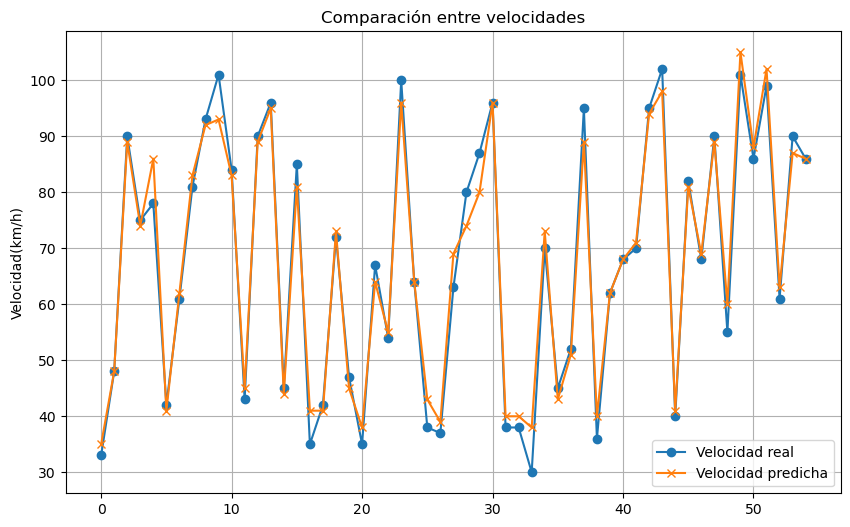

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(all_real_speeds, label='Velocidad real', marker='o')
plt.plot(all_predicted_speeds, label='Velocidad predicha', marker='x')

plt.title('Comparación entre velocidades')
plt.ylabel('Velocidad(km/h)')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

MAE: 2.5272727272727273
RMSE: 3.35477949417625
R^2: 0.9779906698495423


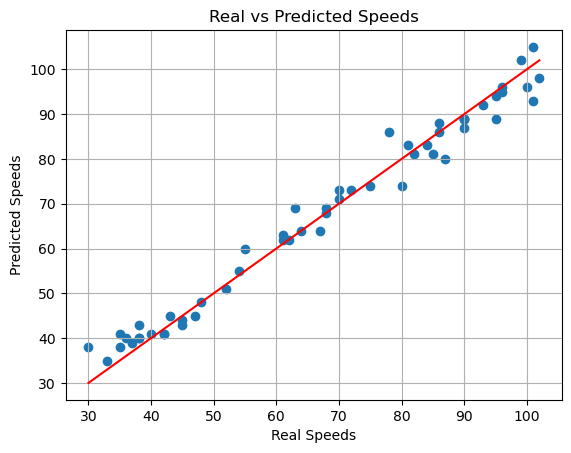

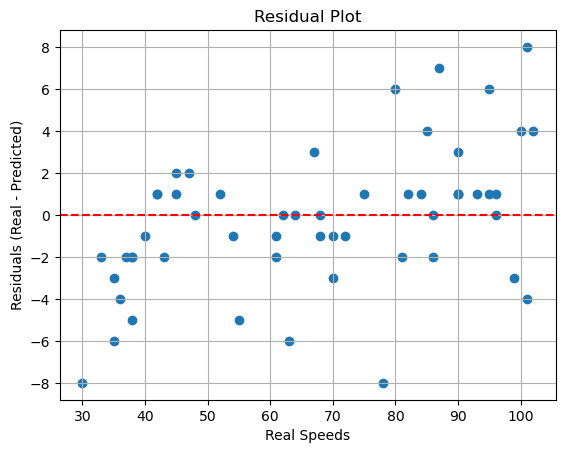

In [57]:
error = all_real_speeds - all_predicted_speeds
mae = mean_absolute_error(all_real_speeds, all_predicted_speeds)
print(f'MAE: {mae}')
rmse = np.sqrt(mean_squared_error(all_real_speeds, all_predicted_speeds))
print(f'RMSE: {rmse}')
r2 = r2_score(all_real_speeds, all_predicted_speeds)
print(f'R^2: {r2}')
plt.scatter(all_real_speeds, all_predicted_speeds)
plt.plot([min(all_real_speeds), max(all_real_speeds)], [min(all_real_speeds), max(all_real_speeds)], color='red')  # Line y=x
plt.xlabel('Real Speeds')
plt.ylabel('Predicted Speeds')
plt.title('Real vs Predicted Speeds')
plt.grid(True)
plt.show()
residuals = all_real_speeds - all_predicted_speeds
plt.scatter(all_real_speeds, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Real Speeds')
plt.ylabel('Residuals (Real - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()  

In [58]:
reproduce_video_from_np(data_loader.data_real_image[27])

In [59]:
data_loader.data_real_speed[27]

64.0

In [60]:
eval_data = torch.tensor(data_loader.data_real_image[27], dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0).to(device)
with torch.no_grad():
    test_output = best_model(eval_data)
torch.round(test_output).int()

tensor([[64]], device='cuda:0', dtype=torch.int32)

In [61]:
reproduce_video_from_np(data_loader.data_real_image[14])

In [62]:
data_loader.data_real_speed[14]

96.0

In [63]:
eval_data = torch.tensor(data_loader.data_real_image[2], dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0).to(device)
with torch.no_grad():
    test_output = best_model(eval_data)
torch.round(test_output).int()

tensor([[89]], device='cuda:0', dtype=torch.int32)

In [64]:
reproduce_video_from_np(data_loader.data_real_image[2])

In [65]:
data_loader.data_real_speed[2]

90.0

In [66]:
eval_data = torch.tensor(data_loader.data_real_image[2], dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0).to(device)
with torch.no_grad():
    test_output = best_model(eval_data)
torch.round(test_output).int()

tensor([[89]], device='cuda:0', dtype=torch.int32)

In [67]:
reproduce_video_from_np(data_loader.data_real_image[4])

In [68]:
data_loader.data_real_speed[4]

78.0

In [69]:
eval_data = torch.tensor(data_loader.data_real_image[4], dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0).to(device)
with torch.no_grad():
    test_output = best_model(eval_data)
torch.round(test_output).int()

tensor([[86]], device='cuda:0', dtype=torch.int32)

In [70]:
eval_data = torch.tensor(data_loader.data_real_image[4], dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0).to(device)
with torch.no_grad():
    test_output = best_model(eval_data)
torch.round(test_output).int()

tensor([[86]], device='cuda:0', dtype=torch.int32)